In [67]:
import warnings
warnings.filterwarnings("ignore")
from run import main
from mtdnetwork.statistics.metrics import Metrics
import matplotlib.pyplot as plt
plt.set_loglevel('WARNING')

In [68]:
# set up dataframe for collecting event data
"""
    start_time: the start time of the simulation (can only be used when you have saved state at that given timestamp)
    finish_time: the total simulation time
    checkpoints: a list of simulation timestamp for state saving e.g. [1000, 5000, 7000]
    scheme: simultaneously, randomly, alternatively, None
"""
SIM_TIME = 10000
scheme = 'randomly'
time_network, adversary = main(start_time=0, finish_time=SIM_TIME, scheme=scheme, checkpoints=[1000, 3000, 5000, 7000])

Adversary: Start SCAN_HOST at 0.0s.
MTD: UserShuffle triggered 0.0s
MTD: UserShuffle deployed in the network at 0.0s.
Adversary: Processed SCAN_HOST at 10.0s.
Adversary: Start ENUM_HOST at 10.0s.
MTD: UserShuffle finished in 20.0s at 20.0s.
Adversary: Processed ENUM_HOST at 25.0s.
Adversary: Start SCAN_PORT at 25.0s.
MTD: OSDiversity triggered 30.7s
MTD: OSDiversity deployed in the network at 30.7s.
Adversary: Processed SCAN_PORT at 45.0s.
Adversary: Start EXPLOIT_VULN at 45.0s.
MTD: PortShuffle triggered 61.6s
MTD: PortShuffle suspended at 61.6s due to resource occupation
MTD: OSDiversity finished in 35.5s at 66.3s.
MTD: Interrupted EXPLOIT_VULN at 66.3s!
Adversary: Restarting with SCAN_PORT at 68.3s!
Adversary: Start SCAN_PORT at 68.3s.
Adversary: Processed SCAN_PORT at 88.3s.
Adversary: Start EXPLOIT_VULN at 88.3s.
MTD: PortShuffle triggered 93.1s
MTD: PortShuffle deployed in the network at 93.1s.
Adversary: Processed EXPLOIT_VULN at 113.5s.
Adversary: Start BRUTE_FORCE at 113.5s.
M

In [69]:
mtd_stats = time_network.get_mtd_stats()
attack_stats = adversary.get_attack_stats()


mtd_stats.save_record(sim_time=SIM_TIME, scheme=scheme)
attack_stats.save_record(sim_time=SIM_TIME, scheme=scheme)
metrics = Metrics(mtd_record=mtd_stats.get_record(), attack_record=attack_stats.get_record())

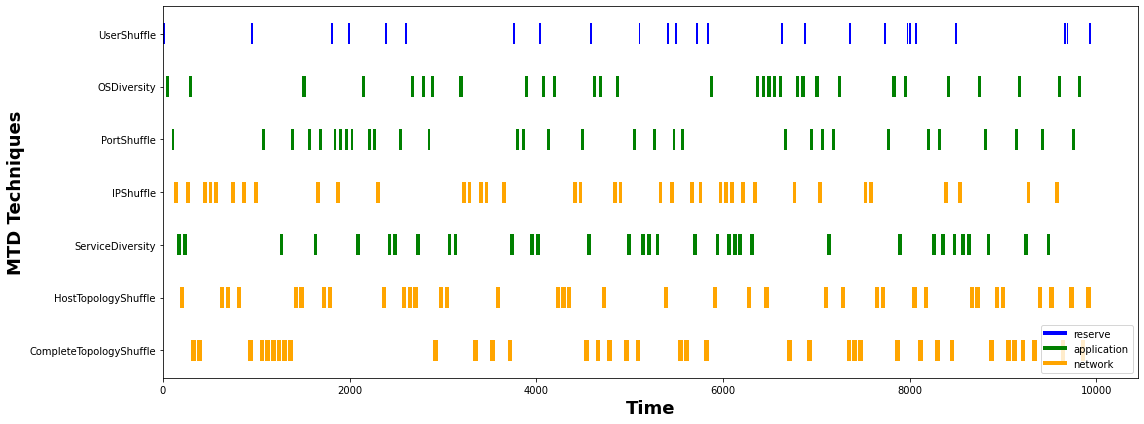

In [70]:
metrics.visualise_mtd_operation()

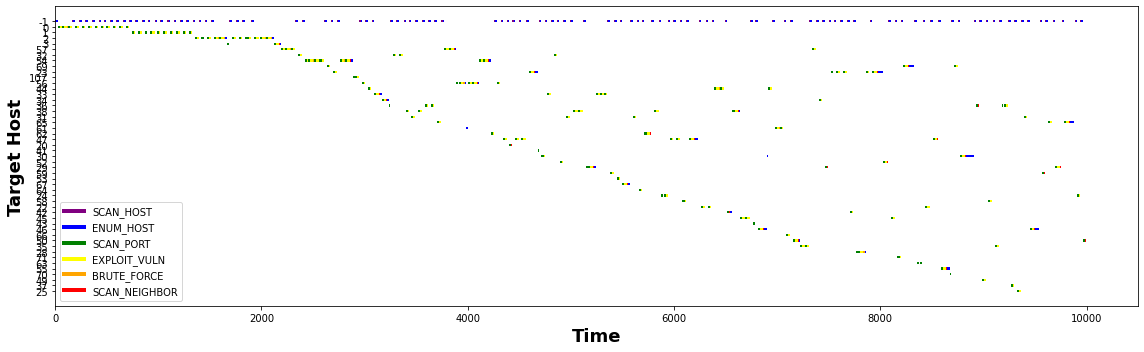

In [71]:
metrics.visualise_attack_operation_group_by_host()

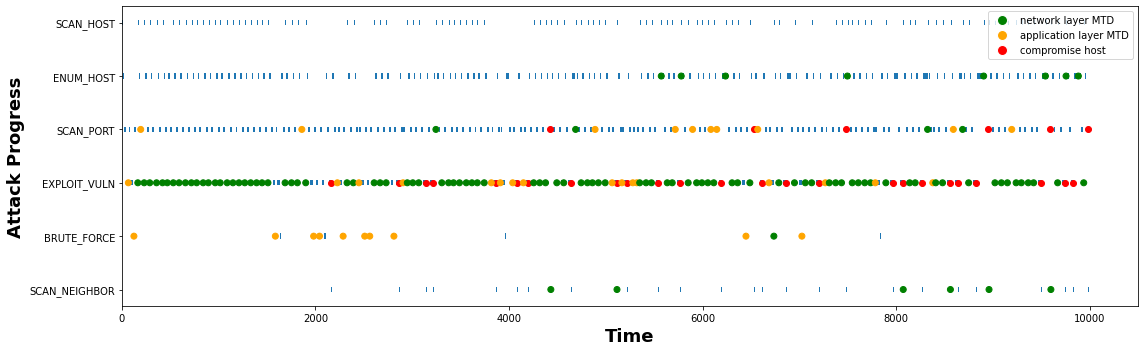

In [72]:
metrics.visualise_attack_operation()

In [73]:
metrics.compromise_record_by_attack_action('SCAN_PORT')

,name,start_time,finish_time,duration,current_host,current_host_uuid,compromise_host,compromise_host_uuid,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_users,interrupted_in,interrupted_by,color
272,SCAN_PORT,4404.270712,4424.270712,20.0,20,f550232a-7ee4-4a18-95e0-7cfb27e07a56,20,f550232a-7ee4-4a18-95e0-7cfb27e07a56,1,216,7,"[Nicole, Pansie, Beverlie]",None,None,green
410,SCAN_PORT,6515.438650,6535.438650,20.0,42,b5b2ee60-d3ca-474c-af79-50f221f44bf8,42,b5b2ee60-d3ca-474c-af79-50f221f44bf8,1,315,14,"[Emily, Elane, Jean]",None,None,green
468,SCAN_PORT,7462.983369,7482.983369,20.0,29,b4001745-2bca-4a7d-802c-1208f09ca955,29,b4001745-2bca-4a7d-802c-1208f09ca955,2,406,18,[Blondy],None,None,green
565,SCAN_PORT,8931.640252,8951.640252,20.0,36,509d942e-4283-483c-86ab-ac638f79a723,36,509d942e-4283-483c-86ab-ac638f79a723,4,425,25,[Sisely],None,None,green
606,SCAN_PORT,9570.091133,9590.091133,20.0,59,c9662c17-97ec-4e8a-862e-a8e4b4739fd8,59,c9662c17-97ec-4e8a-862e-a8e4b4739fd8,2,438,27,"[Tana, Luci, Dorice]",None,None,green
632,SCAN_PORT,9965.559021,9985.559021,20.0,50,380b8dbf-2c82-4c97-916e-db109f88f84b,50,380b8dbf-2c82-4c97-916e-db109f88f84b,2,469,30,"[Ceciley, Mitzi]",None,None,green


In [74]:
metrics.compromise_record_by_attack_action('EXPLOIT_VULN')

,name,start_time,finish_time,duration,current_host,current_host_uuid,compromise_host,compromise_host_uuid,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_users,interrupted_in,interrupted_by,color
135,EXPLOIT_VULN,2139.173309,2165.209080,26.035771,3,aebe5f4b-cf10-49c0-85b5-5ea8f0d42612,3,aebe5f4b-cf10-49c0-85b5-5ea8f0d42612,2,33,0,"[Dorrie, Kacey, Sandy, Carlye, Daphene]",None,None,yellow
175,EXPLOIT_VULN,2832.460919,2859.174411,26.713492,54,5d1e6755-7608-4d68-b9b1-1bdce101d682,54,5d1e6755-7608-4d68-b9b1-1bdce101d682,2,81,1,"[Odessa, Maurene, Megen, Isadora, Lorna]",None,None,yellow
193,EXPLOIT_VULN,3113.809692,3140.557865,26.748173,33,15b778b5-a242-4303-92f4-e9e7ecdd1e93,33,15b778b5-a242-4303-92f4-e9e7ecdd1e93,1,106,2,"[Devonna, Anny, Jonell, Issie, Wendeline]",None,None,yellow
197,EXPLOIT_VULN,3185.557865,3210.901314,25.343449,34,cf7a695e-dae0-4ffd-a0e2-ca8f4ff422b3,34,cf7a695e-dae0-4ffd-a0e2-ca8f4ff422b3,1,112,3,"[Sella, Joice, Dorris, Erminie, Marisa]",None,None,yellow
238,EXPLOIT_VULN,3839.247521,3864.737491,25.489970,57,163e0a9a-237f-4dbe-b9c4-0fd2275eebe0,57,163e0a9a-237f-4dbe-b9c4-0fd2275eebe0,2,126,4,"[Pia, Bell, Bobbee, Petunia]",None,None,yellow
251,EXPLOIT_VULN,4059.796157,4085.226072,25.429915,56,e712b818-4d10-42cf-baec-51b848113b8b,56,e712b818-4d10-42cf-baec-51b848113b8b,3,149,5,"[Caralie, Gaye, Janean, Dorry, Karalynn]",None,None,yellow
257,EXPLOIT_VULN,4170.934901,4196.370478,25.435578,54,4f0b0a2c-3845-488f-8c88-defb4748649e,54,4f0b0a2c-3845-488f-8c88-defb4748649e,3,164,6,"[Sosanna, Estrellita, Franciska, Martelle, Lur...",None,None,yellow
285,EXPLOIT_VULN,4612.069076,4638.454289,26.385213,23,bc4400c0-ef14-4f62-93c8-1725e702142e,23,bc4400c0-ef14-4f62-93c8-1725e702142e,2,216,8,"[Winnah, Mina, Anita, Dyane, Marion]",None,None,yellow
316,EXPLOIT_VULN,5087.396075,5112.941691,25.545616,38,c038ede9-8dc5-4e8a-b6c1-e709891866ed,38,c038ede9-8dc5-4e8a-b6c1-e709891866ed,3,234,9,"[Danyelle, Dot, Marsha]",None,None,yellow
323,EXPLOIT_VULN,5188.233018,5214.419487,26.186469,29,4ed1a440-0847-48fd-b63f-aa018bfccc0d,29,4ed1a440-0847-48fd-b63f-aa018bfccc0d,1,265,10,"[Caprice, Kara, Jenn, Chelsie]",None,None,yellow


In [75]:
metrics.compromise_record_by_attack_action('BRUTE_FORCE')

,name,start_time,finish_time,duration,current_host,current_host_uuid,compromise_host,compromise_host_uuid,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_users,interrupted_in,interrupted_by,color


In [76]:
metrics.mean_time_to_compromise()

105.51060661991723

In [77]:
metrics.mtd_execute_frequency()

42.679280048825305